# From "*Why Batch Normalization helps gradient descent faster*" To "*some fundamentals of multivariat calculus*" 

### 从”为什么 Batch Normalization 会让梯度下降更快速” 到 “一些多元微积分的原理”

Prof Richard Xu, 徐亦达

University of Technology Sydney (UTS)

Yida.Xu@uts.edu.au

2018-02-17

* In batch normalization paper, the key is to have the following **neuron (pesudo) whitenning** process:

在 batch normalization 文章里，关键的一步是对于每层的原子做一些**数据/原子伪白化**的工作

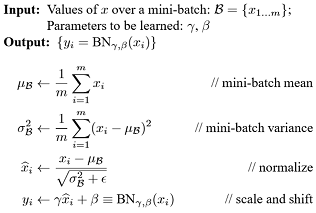

In [4]:
from IPython.core.display import Image 
Image(filename='bn.png')

## Motivation

We use BN as an opportunity/excuse, to disucss the followings:

* What is Data Whitening 
* Why Data Whitening brings symmetric quadratic function which helps faster gradient descent

Some multivariate calculus fundamentals on:

* Why gradient vector is orthogonal to level curve
* Prove why the steepest descent direction is found at $(x_0, y_0)$ is at $f'(x_0, y_0)$

我们利用BN 作为一个契机，讲述一下:

* 啥是数据白化
* 为什么损失函数拥有圆形的水平曲线, 梯度下降会快

我们还说下一些多元微积分的原理

* 为什么梯度向量和水平曲线是垂直的呢
* 证明在$(x_0, y_0)$，梯度下降最大的方向是 $f'(x_0, y_0)$


## 1. Data Whitening 数据白化

To understand what is data whitening: let's started by sampling data from multivariate Gaussian distribution:
$X \sim \mathcal{N}\left(\mu, \Sigma \right)$

首先，想知道啥是数据白化，我们先从多元正态分布产生“非白化”数据 $X \sim \mathcal{N}\left(\mu, \Sigma \right)$

Let $\mu = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$ and 
$\Sigma = \begin{bmatrix} 2 & 1 \\ 1 & 1 \end{bmatrix} $

<function matplotlib.pyplot.show>

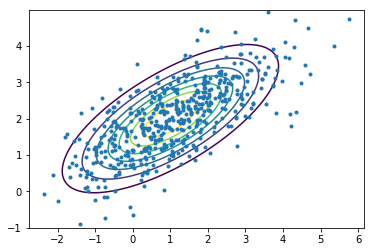

In [5]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline  

mean = [1,2]
Sigma = np.mat([[2,1],[1,1]])
N = 500
data = np.random.multivariate_normal(mean,Sigma,N)
plt.plot(data[:,0], data[:,1],'.')
#print data

delta = 0.025
Xmesh, Ymesh = np.meshgrid(np.arange(mean[0]-3, mean[0]+3, delta),  np.arange(mean[1]-3, mean[1]+3, delta) )

pos = np.empty(Xmesh.shape + (2,))
pos[:, :, 0] = Xmesh
pos[:, :, 1] = Ymesh

from scipy.stats import multivariate_normal
rv = multivariate_normal(mean, Sigma)
plt.contour(Xmesh, Ymesh, rv.pdf(pos))
plt.show

Data whitening means that you need to transform each dimension of data to be distributed as standard Gaussian: $\mathcal{N}(0,1)$ 

1. compute the sample mean $\mu$ and covariance matrix $\Sigma$
2. then transform the data with $x' = \Sigma^{- \frac{1}{2}} (x - \mu) $
Therefore, each dimension: $x' \sim \mathcal{N} \left(\mu, \Sigma \right)$


数据白化就是让数据的每一个维度都是服从标准正态分布， 方法是：

1. 计算出样本的均值 $\mu$ 与协方差矩阵 $\Sigma$
2. 然后把数据样本转化成 $x' = \Sigma^{ - \frac{1}{2}} (x - \mu) $

然后，$x'$ 的每一个维度都是服从标准正态分布

<class 'numpy.matrixlib.defmatrix.matrix'>


<function matplotlib.pyplot.show>

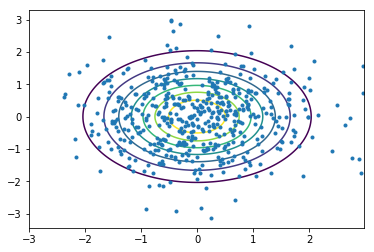

In [6]:
from scipy import linalg

s_mean = np.mean(data,axis=0)
s_Sigma = np.cov(np.transpose(data))

# mean subtracted array
mean_array = np.reshape(np.repeat(s_mean,data.shape[0]),[data.shape[0],-1],1)

inv_Sigma = np.mat(linalg.fractional_matrix_power(s_Sigma, -0.5))
print type(inv_Sigma)

data_prime = inv_Sigma * np.transpose(data - mean_array)

data_prime = np.transpose(data_prime)

# note that plt.plot treats horizontal and vertical data very differently
plt.plot(data_prime[:,0], data_prime[:,1],'.')

delta = 0.025
Xmesh, Ymesh = np.meshgrid(np.arange(-3.0, 3.0, delta),  np.arange(-3.0, 3.0, delta) )
pos = np.empty(Xmesh.shape + (2,))
pos[:, :, 0] = Xmesh
pos[:, :, 1] = Ymesh

from scipy.stats import multivariate_normal
rv = multivariate_normal(np.array(np.mean(data_prime,axis=0)).ravel(), np.cov(np.transpose(data_prime)))
plt.contour(Xmesh, Ymesh, rv.pdf(pos))
plt.show


### Batch normalization isn't "true data whitening"

* Note that Batch Normalization algorithm is NOT a true data whitening, i.e., the paper performs whitening on each dimension independently. Therefore, making it somewhat restrictive. For this reason, introducing the scale $\gamma$ and shift $\beta$ helps for flexibility

注意在 Batch Normalization 算法中的实现还不是真正意义上的数据白化，以为BN算法是对原子的每一个维度独立做白化。所以可能比较受限。故此提出加了两个参数 $\gamma$ 和 $\beta$ 增加模型的灵活度

## 2. Batch Normalization

Imagine we have the following error/loss function: (we demonstrate it using 2-d)

想象一下我们有以下的损失函数:

$\begin{equation} 
\mathcal{L}_{\bf w}(X,Y) = \mathbb{E}_{{\bf x} \sim } \left[ \sum_{i=1}^N \left( y_i - {\bf w}^\top {\bf x}_i \right)^2 \right] \\
%---------------------
= \mathbb{E}_{{\bf x} \sim } \left[ \sum_{i=1}^N y_i^2 - 2 y_i {\bf w}^\top {\bf x}_i + ( {\bf w}^\top {\bf x}_i )^2  \right] \\
= \mathbb{E}_{{\bf x} \sim } \left[ \sum_{i=1}^N y_i^2 - 2 y_i (w_1 x_1 + w_2 x_2 ) + ( w_1 x_1 + w_2 x_2 )^2  \right] \\
= \sum_{i=1}^N y_i^2 - 2 y_i w_1 \mathbb{E}_{x_1 \sim } \big[x_1 \big] - 2 y_i w_2 \mathbb{E}_{x_2 \sim } \big[ x_2 \big] + w_1^2  \mathbb{E}_{x_1 \sim } \big[ x_1^2 \big] + w_2^2 \mathbb{E}_{x_2 \sim } \big[ x_2^2 \big] + 2 w_1 w_2 \mathbb{E}_{ {\bf x} \sim } \big[ x_1 x_2 \big] \\
\end{equation}
$

### "whitened" neurons: 

* In Batch Normalization, we force neuron at each layer $x_1 \sim \mathcal{N}(0,1)$ and $x_2 \sim \mathcal{N}(0,1)$ Therefore a lot of terms in the above becomes zero.

用Batch Normalization, 我们硬是让每层的神经原子$x_1$ and $x_1$从标准正态分布产生的, 所以上面的损失函数很多项都成为零了：

$\mathcal{L}_{\bf w}(X,Y) = 
\sum_{i=1}^N y_i^2 + w_1^2  \mathbb{E}_{x_1 \sim } \big[ x_1^2 \big] + w_2^2 \mathbb{E}_{x_2 \sim } \big[ x_2^2 \big] \\
$

* Then the error surface $\mathcal{L}_{\bf w}(X,Y)$ is a symmetric quadratic, i.e., its level contour is circular, rather than elliptical:

损失函数也成为“对称”的二次函数，他的水平曲线是圆形而不是椭圆型

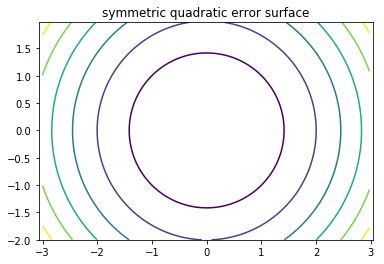

In [11]:
import numpy as np
import matplotlib.pyplot as plt

data_prime = np.array(data_prime)

@np.vectorize
def objective(w0, w1):
    return sum((data_prime[:,0] *  np.repeat(w0,N))**2 + (data_prime[:,1] *  np.repeat(w1,N))**2)

delta = 0.025
W0mesh, W1mesh = np.meshgrid(np.arange(-3.0, 3.0, delta),  np.arange(-2.0, 2.0, delta))

Z = objective(W0mesh, W1mesh)

plt.figure()
plt.contour(W0mesh, W1mesh, Z)
plt.title('symmetric quadratic error surface')
plt.axes().set_aspect('equal', 'datalim')

We know that if we have an error function has square contour, the gradient descent is going to be much faster.

我们都知道如果损失函数拥有圆形的水平曲线, 梯度下降会快.

## 3. Convergence for Error/loss function

* So why does error surface with circular level contour results much faster gradient descent? Let's take a look at **symmetric quadratic** error surface, and **unsymmetric quadratic** error surface

为啥如果损失函数拥有圆形的水平曲线, 梯度下降会快很快？我们分别比较**对称二次函数**和**非对称二次函数**

### symmetric quadratic error surface  对称二次函数

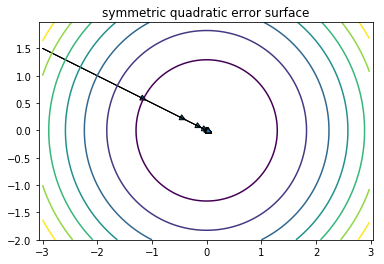

In [8]:
import numpy as np
import matplotlib.pyplot as plt

const = 3;

weight_matrix = np.mat([[const, 0],[0, const]])


@np.vectorize
def objective(w0, w1):
    return np.mat([w0,w1]) * weight_matrix * np.mat([[w0], [w1]])

def derivative(w0, w1):
    return 2 * np.array(np.mat([w0,w1]) * weight_matrix).ravel()

delta = 0.025
W0mesh, W1mesh = np.meshgrid(np.arange(-3.0, 3.0, delta),  np.arange(-2.0, 2.0, delta))

Z = objective(W0mesh, W1mesh)

plt.figure()
plt.contour(W0mesh, W1mesh, Z)

MAX_ITER = 20

pt = [-3,1.5]
learning_rate = 0.1

ax = plt.axes()

for t in range(MAX_ITER):
    
    pt_temp = pt - learning_rate * derivative(pt[0], pt[1])
    ax.arrow(pt[0], pt[1], pt_temp[0] - pt[0], pt_temp[1] - pt[1], head_width=0.1, head_length=0.1)    
    pt = pt_temp

plt.title('symmetric quadratic error surface')
plt.axes().set_aspect('equal', 'datalim')


### unsymmetric quadratic error surface 非对称二次函数

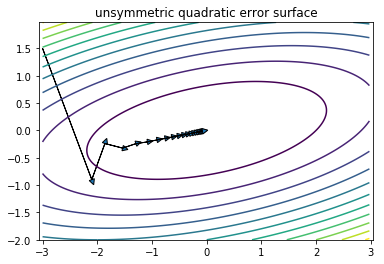

In [9]:
import numpy as np
import matplotlib.pyplot as plt

const = 3;

weight_matrix = np.mat([[const/2, -1],[-1, const*2]])

@np.vectorize
def objective(w0, w1):
    return np.mat([w0,w1]) * weight_matrix * np.mat([[w0], [w1]])

def derivative(w0, w1):
    return 2 * np.array(np.mat([w0,w1]) * weight_matrix).ravel()

delta = 0.025
W0mesh, W1mesh = np.meshgrid(np.arange(-3.0, 3.0, delta),  np.arange(-2.0, 2.0, delta))

Z = objective(W0mesh, W1mesh)

plt.figure()
plt.contour(W0mesh, W1mesh, Z,11)

MAX_ITER = 20

pt = [-3,1.5]
learning_rate = 0.1

ax = plt.axes()

for t in range(MAX_ITER):
    
    pt_temp = pt - learning_rate * derivative(pt[0], pt[1])
    ax.arrow(pt[0], pt[1], pt_temp[0] - pt[0], pt_temp[1] - pt[1], head_width=0.1, head_length=0.1)    
    pt = pt_temp

plt.title('unsymmetric quadratic error surface')
plt.axes().set_aspect('equal', 'datalim')

## 4. Extra stuff: why gradient vector is orthogonal to level curve?
## 为什么梯度向量和水平曲线是垂直的呢？

The gradient vector $f'(x_0, y_0)$ is orthogonal to tangent of level curve $f(x,y) = k$ at point $(x_0, y_0)$. 

But why?
是为啥呢？

* Let $P = (x_0, y_0)$

* There is a particular level curve $f(x,y) = k$ that contains $P$ (of course, not every level curve contains $P$)

我们找出一个水平曲线 $f(x,y) = k$ 让 $P$ 也在此曲线上。(当然 $P$ 不可能出现在任意的水平曲线上)

* We let parametric vector equation of this level curve to be ${\bf r}(t) = \big( x(t), y(t) \big)$, for example: $\big( x(t) = A \cos(t), y(t) = B \sin(t) \big)$

我们让这个水平曲线的向量公式是 ${\bf r}(t) = \big( x(t), y(t) \big)$

* Suppose $t_0$ be the value of $t$ such that:

${\bf r}(t_0) = \big( x(t_0), y(t_0) \big) = ( x_0, y_0)$



* Because of the level curve $f(x,y) = k$:

$f \big( x(t), y(t)\big) = k \implies \frac{\text{d} f}{ \text{d} t} = f'(x,y)^\top {\bf r}'(t) = 0
$

Note that ${\bf r}'(t_0)$ is the tangent vector at point ${\bf r} (t_0)$

这个很关键，${\bf r}'(t_0)$ 是水平曲线 ${\bf r} (t_0)$的切线

* now we substitute $t=t_0$:

$
f'(x_0, y_0)^\top {\bf r}'(t_0) = 0
$

* Therefore, gradient vector $f'(x_0, y_0)$ is orthogonal to tangent of level curve $f(x,y) = k$ at point $(x_0, y_0)$. 


### Example

* In this example, we let $\underbrace{\frac{x^2}{A^2} + \frac{y^2}{B^2}}_{f(x,y)} = \underbrace{1}_{k}$

* gradient vector is: $\frac{\partial f}{\partial x, \partial y} = \left[ \frac{2 x}{A^2}, \frac{2 y}{B^2} \right]$

* the level contour is: ${\bf r}(x(t),y(t)) = [ A \cos(t), B \sin(t) ]$

* $\frac{\text{d} \left( {\bf r}(x(t),y(t)) \right) }{\text{d} t} = [ - A \sin(t), B \cos(t) ]$

We let $t_0 = 0.5 \implies P = [A \cos(0.5), B \sin(0.5)]$

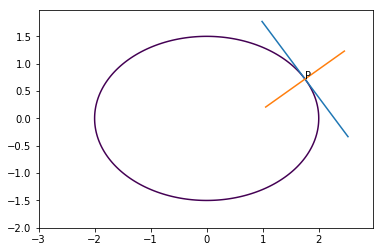

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt

A = 2
B = 1.5

t = 0.5
k = 1

x_0 = A*math.cos(t);
y_0 = B*math.sin(t);

P = [x_0,y_0]

# [df/dx, df/dy]
d_func = [2*P[0]/A**2,2*P[1]/B**2]

# dR/dt = [dx/dt, dy/dt]
d_R = [-A*math.sin(t), B*math.cos(t)]


delta = 0.025
X, Y = np.meshgrid(np.arange(-3.0, 3.0, delta),  np.arange(-2.0, 2.0, delta))

# this is to plot an implicit function
l_length = 0.8

plt.contour(X, Y, X**2/(A**2) + Y**2/(B**2), [k])
plt.text(P[0],P[1], "P")

# plot the gradient of the contour
plt.plot([P[0] - d_R[0] * l_length, P[0] +  d_R[0] * l_length ], 
         [P[1] - d_R[1] * l_length, P[1] +  d_R[1] * l_length ])


# plot the gradient of steepest descent

plt.plot([P[0] - d_func[0] * l_length, P[0] +  d_func[0] * l_length ], 
         [P[1] - d_func[1] * l_length, P[1] +  d_func[1] * l_length ])



## 5. Prove why steepest descent direction found at $(x_0, y_0)$ is at $f'(x_0, y_0)$

## 证明在$(x_0, y_0)$，梯度下降最大的方向是 $f'(x_0, y_0)$

####  Directional derivative of $f$ in direction ${\bf u}$ 

* Let ${\bf u}$ be unit vector $\|u \| = 1$. 
* Therefore, directional derivative of $f$ in direction ${\bf u}$ is defined as limit:

$\text{D}_{\bf u} ({\bf a}) = \lim_{h \rightarrow 0} \frac{f ( {\bf a} + h {\bf u} ) - f({\bf a}) }{ h}$:

* Let ${\bf u} = u_1 {\bf e}_1 + u_1 {\bf e}_1 + \cdots + u_n {\bf e}_n$:

* Let **taylor expansion** of degree 1 of $f$ to be $\tilde{f}$ around point ${\bf a}$

$\tilde{f}(x) \approx f({\bf a}) + \frac{\partial f}{\partial x_1}({\bf a})(x_1 - a_1) + \cdots +  \frac{\partial f}{\partial x_n} ({\bf a})(x_n - a_n)$:

* by substitute $x = {\bf a} + h {\bf u}$:

$\tilde{f}({\bf a} + hu) \approx f({\bf a}) + \frac{\partial f}{\partial x_1} ({\bf a})(\underbrace{a_1 + h u_1}_{x_1} - a_1) + \cdots +  \frac{\partial f}{\partial x_n} ( {\bf a} )(\underbrace{a_n + h u_n}_{x_n} - a_n)\\
=  f({\bf a}) + \frac{\partial f}{\partial x_1}({\bf a})(h u_1 ) + \cdots +  \frac{\partial f}{\partial x_n} ({\bf a})(h u_n )\\
=  f({\bf a}) + h \left( \frac{\partial f}{\partial x_1}({\bf a})(u_1 ) + \cdots +  \frac{\partial f}{\partial x_n} ({\bf a})( u_n )\right)\\
=  h \big( \triangledown f ({\bf a})^\top {\bf u} \big)
$

* Therefore, 


$\text{D}_{\bf u} (a) = \lim_{h \rightarrow 0} \frac{ f ( {\bf a} + h {\bf u}) - f({\bf a})}{ h}\\
= \lim_{h \rightarrow 0} \frac{\tilde{f} ( {\bf a} + h {\bf u}) - f({\bf a})}{ h}\\
= \lim_{h \rightarrow 0} \frac{h \big( \triangledown f ({\bf a})^\top {\bf u} \big)}{ h}\\
= \triangledown f ({\bf a})^\top {\bf u}
$

#### maximum and minimum value of $\triangledown f ({\bf a})^\top {\bf u}$

Since ${\bf u}$ can be any unit vector, it is clear that: 

* dot product: $\triangledown f ({\bf a})^\top {\bf u} = \| \triangledown f ({\bf a}) \| \cos(\theta)$ 
* $\text{D}_{\bf u} (a)$ has maximum when ${\bf u}$ in **same direction** as $\triangledown f ({\bf a})$, i.e., $\theta = 0$
* $\text{D}_{\bf u} (a)$ has minimum when ${\bf u}$ in **opposite direction** as $\triangledown f ({\bf a})$, i.e., $\theta = \pi$